## Problem 12: Quantum Fourier Transform [8 points]

Write the code in Qiskit for QFT and check it for the case of n = 3 Qubits.

The solution made by following Qiskit textbook

In [1]:
from qiskit import *
from numpy import pi
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.tools.monitor import job_monitor

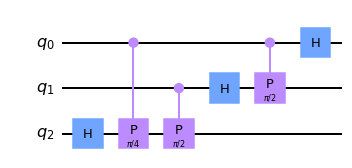

In [4]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

# Let's see how it looks:
qc = QuantumCircuit(3)
qft_rotations(qc,3)
qc.draw('mpl')

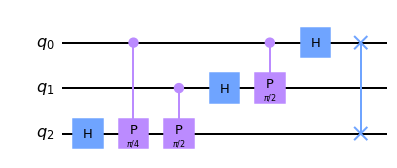

In [5]:

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(3)
qft(qc,3)
qc.draw('mpl')

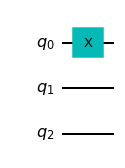

In [6]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 1
qc.x(0)
#qc.x(1)
#qc.x(2)
qc.draw('mpl')

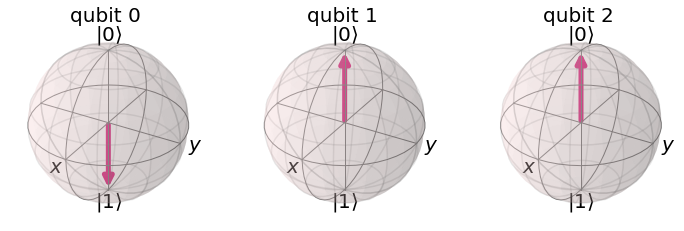

In [7]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

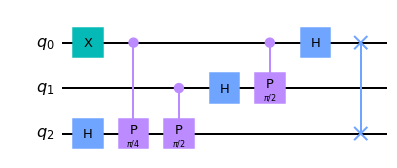

In [8]:
qft(qc,3)
qc.draw('mpl')

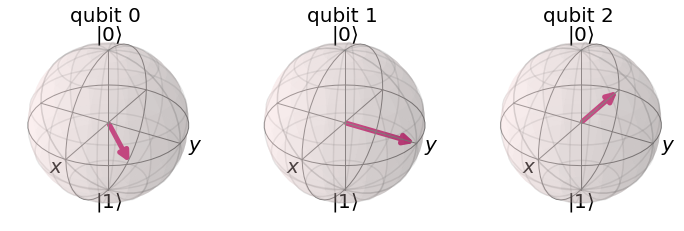

In [9]:
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

Compared the the state |+++> Qubit 0 has been rotated by 1/8 of a full turn, qubit 1 by 1/4 full turns and qubit 2 by 1/2 of a full turn.



In [10]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates


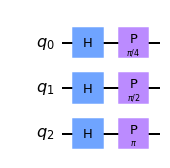

In [11]:
nqubits = 3
number = 1
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw('mpl')

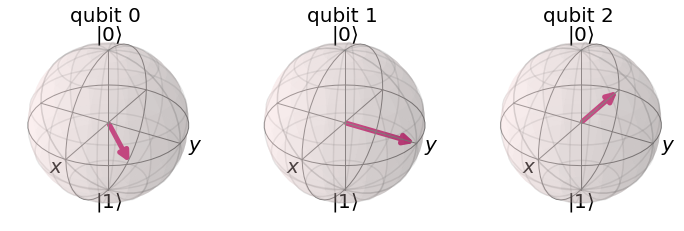

In [12]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

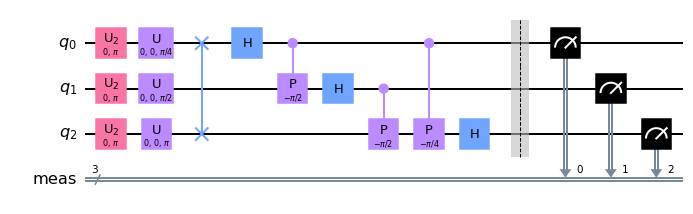

In [13]:
qc = inverse_qft(qc,nqubits)
qc.measure_all()
qc.draw('mpl')

In [26]:
IBMQ.load_account()
from qiskit.providers.ibmq import least_busy
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2021-04-12 22:55:05,871: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_quito


In [27]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(transpiled_qc, shots=shots)
job = backend.run(qobj)
job_monitor(job)

<ipython-input-27-c72f574f7484>:4: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


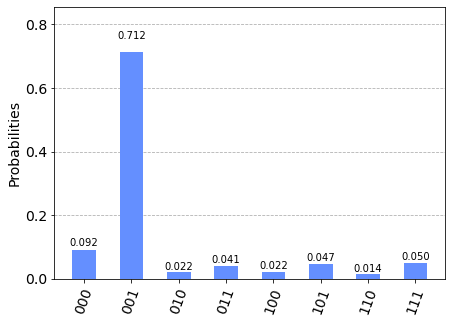

In [28]:
counts = job.result().get_counts()
plot_histogram(counts)